In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# LeNet for MNIST using Keras and TensorFlow

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LeakyReLU
from keras.utils import np_utils
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras import optimizers
from keras.models import load_model
np.random.seed(2)


# use GPU mem incrementally
import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# from keras import backend as K
# K.set_session(sess)


Using TensorFlow backend.


In [3]:
# import for c3d
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *

In [4]:
from utils import *
from neurallogic import *
from lenet import *
from data_prepare import *
from intergrated_model import *

In [5]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 12345
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [6]:
# set global parameters
plot_epoch = 200

saved_result_data = 'result_data/marc_sim_0.pkl'

# CE definition

In [7]:
simulation_name = 'marc_sim_0'

############## CE definition ##############

NL_model_name = 'NL_' + simulation_name
PL_model_name = 'PNL_' + simulation_name


num_event_type = 10   # total num of unique events  3x3 + 1 unknown
num_attribute = 1      # total num of attribute (int)

ce_fsm_list = [ [1, 2, 3],  [4,5,6],  [7,8,9], [1, 10] ]
ce_time_list = [ np.array([ [INF, INF], [0, 0]]),  
                np.array([ [INF, INF ], [0, 0 ]]),  
                np.array([ [INF, INF], [0, 0]]),
                np.array([[INF], [0]])]

event_num = 100000
window_size = 5

# Training Neural Logic Models

In [8]:
train_neurallogic_model(NL_model_name,
                            num_event_type, num_attribute,
                            ce_fsm_list, ce_time_list,
                            window_size,
                            event_num ,
                            verify_logic = False,
                            diagnose = True)

NeuralLogic model exists in:  saved_model/NL_marc_sim_0.hdf5


In [9]:
# Returns a compiled model identical to the previous one
loading_path = 'saved_model/'+NL_model_name+'.hdf5'
neuralLogic_model = load_model(loading_path)
neuralLogic_model.name="neurallogic"
print('Loading model successfully from ', loading_path)

Loading model successfully from  saved_model/NL_marc_sim_0.hdf5


# Preparing all dataset required

In [10]:
mnist_event_num = 100000

In [11]:
mnist_data_event_path = PL_model_name+'_data_' + str(mnist_event_num) +'.npz'
mnist_data_event, data_feature, data_label = generate_mnist_event_data(num_event_type, num_attribute, 
                                                                          ce_fsm_list, ce_time_list,
                                                                          mnist_event_num, window_size,
                                                                          mnist_data_event_path)

Data file exists in:  data/PNL_marc_sim_0_data_100000.npz


In [12]:
if np.ndim(data_label)==1:
    data_label = np.expand_dims(data_label, axis = 1)

# valid_index = (data_label!= 999)# choose valid data samples
valid_index = (data_label.sum(axis = 1)!= 0)
v_mnist_data_event  =  mnist_data_event[valid_index, ]
v_data_label = data_label[valid_index, ]
print('Valid data (with valid CE) shape: ')
print("Data:\t", v_mnist_data_event.shape)
print("Label:\t", v_data_label.shape)

Valid data (with valid CE) shape: 
Data:	 (4876, 5, 28, 28, 1)
Label:	 (4876, 4)


In [13]:
# prepare the testing MNIST dataset for customized LeNet
mnist_label = list(range(num_event_type)) # 
mnist_x_test, mnist_y_test = generate_customized_mnist_data(mnist_label, num_event_type)

Testing mnist feature shape:  (10000, 28, 28, 1)
Testing mnist label shape:  (10000, 10)


In [14]:
# add data normalization
v_mnist_data_event = v_mnist_data_event *2 -1
mnist_x_test = mnist_x_test *2 -1

# 1.Training in end2end fashion:
### MSE loss + Adam(0.001)
### Combined loss doesn't work really well, stucked at local minima

In [15]:
# generate a new LeNet model from scratch
lenetModel = LeNet_mnist(num_output = num_event_type)  # 2 events
lenetModel.name="lenetModel"
score = lenetModel.evaluate(mnist_x_test, mnist_y_test, verbose=1)
print('Test loss: %3f,  \t \tTest Accuracy: %4f'%(score[0], score[1]))

final_model = intergrated_model(lenetModel, neuralLogic_model, 
                                window_size, num_event_type,
                                omega_value = 1e-4,
                                load_nl_weights = True,
                                nl_trainable = False,
                                loss = 'combined_loss',  # use semantic loss here
                                diagnose = False)
# loss = combined_loss / mse_loss

10000/10000 [==============================] - 2s 225us/step
Test loss: 2.341936,  	 	Test Accuracy: 0.083400
Model input:  Tensor("input_1:0", shape=(None, 5, 28, 28, 1), dtype=float32)
Model output:  Tensor("dense_3/BiasAdd:0", shape=(None, 4), dtype=float32)

===== NL model weights loaded =====

===== Neural Logic module freezed.=====

===== Loss Func: Combined Loss =====
 Omega =  0.0001


In [16]:
plot_epoch = 500
epochs = plot_epoch
diagnose = True

save_path = 'saved_model/'+ PL_model_name +'.hdf5'
es = EarlyStopping(monitor='val_MAE', mode='min', verbose=1, patience=plot_epoch)
mc = ModelCheckpoint(save_path, monitor='val_MAE', mode='min', verbose=diagnose, save_best_only=True)
cb_list = [es, mc]

print('The maximum training epochs is: ', epochs)
H = final_model.fit( v_mnist_data_event ,v_data_label, 
                        batch_size = 256, 
                        epochs = epochs,
                        verbose=diagnose,
                        shuffle=True,
                        callbacks=cb_list,
                        validation_split = 0.2)

hist_NL = H

The maximum training epochs is:  500
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Train on 3900 samples, validate on 976 samples
Epoch 1/500
3900/3900 [==============================] - 1s 369us/step - loss: 0.2316 - MAE: 0.2208 - val_loss: 0.1581 - val_MAE: 0.1788

Epoch 00001: val_MAE improved from inf to 0.17881, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 2/500
3900/3900 [==============================] - 1s 134us/step - loss: 0.1558 - MAE: 0.1810 - val_loss: 0.1387 - val_MAE: 0.1717

Epoch 00002: val_MAE improved from 0.17881 to 0.17171, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 3/500
3900/3900 [==============================] - 1s 133us/step - loss: 0.1339 - MAE: 0.1622 - val_loss: 0.1250 - val_MAE: 0.1508

Epoch 00003: val_MAE improved from 0.17171 to 0.15076, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 4/500
3900/3900 [==============================] - 1s 132us/step - loss: 

Epoch 35/500
3900/3900 [==============================] - 1s 133us/step - loss: 0.0420 - MAE: 0.0444 - val_loss: 0.0504 - val_MAE: 0.0524

Epoch 00035: val_MAE improved from 0.05379 to 0.05245, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 36/500
3900/3900 [==============================] - 1s 133us/step - loss: 0.0405 - MAE: 0.0418 - val_loss: 0.0484 - val_MAE: 0.0485

Epoch 00036: val_MAE improved from 0.05245 to 0.04846, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 37/500
3900/3900 [==============================] - 1s 132us/step - loss: 0.0398 - MAE: 0.0406 - val_loss: 0.0469 - val_MAE: 0.0477

Epoch 00037: val_MAE improved from 0.04846 to 0.04770, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 38/500
3900/3900 [==============================] - 1s 133us/step - loss: 0.0391 - MAE: 0.0395 - val_loss: 0.0469 - val_MAE: 0.0474

Epoch 00038: val_MAE improved from 0.04770 to 0.04742, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 39/500
3900/3900 [========

3900/3900 [==============================] - 1s 133us/step - loss: 0.0011 - MAE: 0.0043 - val_loss: 0.0104 - val_MAE: 0.0154

Epoch 00073: val_MAE did not improve from 0.01507
Epoch 74/500
3900/3900 [==============================] - 1s 133us/step - loss: 9.4199e-04 - MAE: 0.0039 - val_loss: 0.0109 - val_MAE: 0.0152

Epoch 00074: val_MAE did not improve from 0.01507
Epoch 75/500
3900/3900 [==============================] - 1s 134us/step - loss: 9.1849e-04 - MAE: 0.0038 - val_loss: 0.0106 - val_MAE: 0.0154

Epoch 00075: val_MAE did not improve from 0.01507
Epoch 76/500
3900/3900 [==============================] - 1s 133us/step - loss: 8.3465e-04 - MAE: 0.0036 - val_loss: 0.0103 - val_MAE: 0.0148

Epoch 00076: val_MAE improved from 0.01507 to 0.01475, saving model to saved_model/PNL_marc_sim_0.hdf5
Epoch 77/500
3900/3900 [==============================] - 1s 133us/step - loss: 8.2445e-04 - MAE: 0.0035 - val_loss: 0.0103 - val_MAE: 0.0148

Epoch 00077: val_MAE did not improve from 0.01475

3900/3900 [==============================] - 1s 132us/step - loss: 7.3904e-04 - MAE: 0.0030 - val_loss: 0.0110 - val_MAE: 0.0148

Epoch 00154: val_MAE did not improve from 0.01457
Epoch 155/500
3900/3900 [==============================] - 1s 133us/step - loss: 7.3894e-04 - MAE: 0.0030 - val_loss: 0.0110 - val_MAE: 0.0148

Epoch 00155: val_MAE did not improve from 0.01457
Epoch 156/500
3900/3900 [==============================] - 1s 133us/step - loss: 7.3879e-04 - MAE: 0.0030 - val_loss: 0.0110 - val_MAE: 0.0148

Epoch 00156: val_MAE did not improve from 0.01457
Epoch 157/500
3900/3900 [==============================] - 1s 133us/step - loss: 7.3869e-04 - MAE: 0.0030 - val_loss: 0.0110 - val_MAE: 0.0148

Epoch 00157: val_MAE did not improve from 0.01457
Epoch 158/500
3900/3900 [==============================] - 1s 134us/step - loss: 7.3863e-04 - MAE: 0.0030 - val_loss: 0.0110 - val_MAE: 0.0147

Epoch 00158: val_MAE did not improve from 0.01457
Epoch 159/500
3900/3900 [===================

3900/3900 [==============================] - 1s 134us/step - loss: 0.0016 - MAE: 0.0034 - val_loss: 0.0129 - val_MAE: 0.0140

Epoch 00238: val_MAE did not improve from 0.01308
Epoch 239/500
3900/3900 [==============================] - 1s 133us/step - loss: 0.0016 - MAE: 0.0034 - val_loss: 0.0129 - val_MAE: 0.0141

Epoch 00239: val_MAE did not improve from 0.01308
Epoch 240/500
3900/3900 [==============================] - 1s 133us/step - loss: 0.0016 - MAE: 0.0034 - val_loss: 0.0131 - val_MAE: 0.0143

Epoch 00240: val_MAE did not improve from 0.01308
Epoch 241/500
3900/3900 [==============================] - 1s 132us/step - loss: 0.0016 - MAE: 0.0034 - val_loss: 0.0130 - val_MAE: 0.0142

Epoch 00241: val_MAE did not improve from 0.01308
Epoch 242/500
3900/3900 [==============================] - 1s 133us/step - loss: 0.0016 - MAE: 0.0034 - val_loss: 0.0132 - val_MAE: 0.0143

Epoch 00242: val_MAE did not improve from 0.01308
Epoch 243/500
3900/3900 [==============================] - 1s 13

3900/3900 [==============================] - 1s 144us/step - loss: 0.0014 - MAE: 0.0032 - val_loss: 0.0140 - val_MAE: 0.0147

Epoch 00324: val_MAE did not improve from 0.01308
Epoch 325/500
3900/3900 [==============================] - 1s 142us/step - loss: 0.0014 - MAE: 0.0032 - val_loss: 0.0140 - val_MAE: 0.0147

Epoch 00325: val_MAE did not improve from 0.01308
Epoch 326/500
3900/3900 [==============================] - 1s 147us/step - loss: 0.0014 - MAE: 0.0032 - val_loss: 0.0140 - val_MAE: 0.0147

Epoch 00326: val_MAE did not improve from 0.01308
Epoch 327/500
3900/3900 [==============================] - 1s 136us/step - loss: 0.0014 - MAE: 0.0032 - val_loss: 0.0140 - val_MAE: 0.0147

Epoch 00327: val_MAE did not improve from 0.01308
Epoch 328/500
3900/3900 [==============================] - 1s 141us/step - loss: 0.0014 - MAE: 0.0032 - val_loss: 0.0140 - val_MAE: 0.0147

Epoch 00328: val_MAE did not improve from 0.01308
Epoch 329/500
3900/3900 [==============================] - 1s 14

3900/3900 [==============================] - 1s 143us/step - loss: 0.0014 - MAE: 0.0031 - val_loss: 0.0134 - val_MAE: 0.0141

Epoch 00410: val_MAE did not improve from 0.01308
Epoch 411/500
3900/3900 [==============================] - 1s 144us/step - loss: 0.0014 - MAE: 0.0031 - val_loss: 0.0134 - val_MAE: 0.0141

Epoch 00411: val_MAE did not improve from 0.01308
Epoch 412/500
3900/3900 [==============================] - 1s 140us/step - loss: 0.0014 - MAE: 0.0031 - val_loss: 0.0134 - val_MAE: 0.0141

Epoch 00412: val_MAE did not improve from 0.01308
Epoch 413/500
3900/3900 [==============================] - 1s 144us/step - loss: 0.0014 - MAE: 0.0031 - val_loss: 0.0134 - val_MAE: 0.0141

Epoch 00413: val_MAE did not improve from 0.01308
Epoch 414/500
3900/3900 [==============================] - 1s 144us/step - loss: 0.0014 - MAE: 0.0031 - val_loss: 0.0134 - val_MAE: 0.0141

Epoch 00414: val_MAE did not improve from 0.01308
Epoch 415/500
3900/3900 [==============================] - 1s 14


Epoch 00495: val_MAE did not improve from 0.01209
Epoch 496/500
3900/3900 [==============================] - 1s 143us/step - loss: 0.0032 - MAE: 0.0048 - val_loss: 0.0119 - val_MAE: 0.0131

Epoch 00496: val_MAE did not improve from 0.01209
Epoch 497/500
3900/3900 [==============================] - 1s 139us/step - loss: 0.0030 - MAE: 0.0046 - val_loss: 0.0113 - val_MAE: 0.0124

Epoch 00497: val_MAE did not improve from 0.01209
Epoch 498/500
3900/3900 [==============================] - 1s 144us/step - loss: 0.0030 - MAE: 0.0046 - val_loss: 0.0115 - val_MAE: 0.0125

Epoch 00498: val_MAE did not improve from 0.01209
Epoch 499/500
3900/3900 [==============================] - 1s 145us/step - loss: 0.0030 - MAE: 0.0046 - val_loss: 0.0115 - val_MAE: 0.0125

Epoch 00499: val_MAE did not improve from 0.01209
Epoch 500/500
3900/3900 [==============================] - 1s 140us/step - loss: 0.0030 - MAE: 0.0046 - val_loss: 0.0117 - val_MAE: 0.0126

Epoch 00500: val_MAE did not improve from 0.01209

# Moniter the lenet performance 

In [20]:

lenet_score1 = lenetModel.evaluate(mnist_x_test, mnist_y_test, verbose=0)
print('Test loss: %3f,  \t \tTest Accuracy: %4f'%(lenet_score1[0], lenet_score1[1]))

Test loss: 0.616644,  	 	Test Accuracy: 0.978200
Proposed acc:	 0.978200


# Learning curves

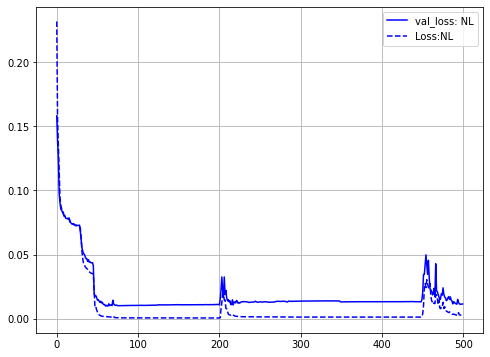

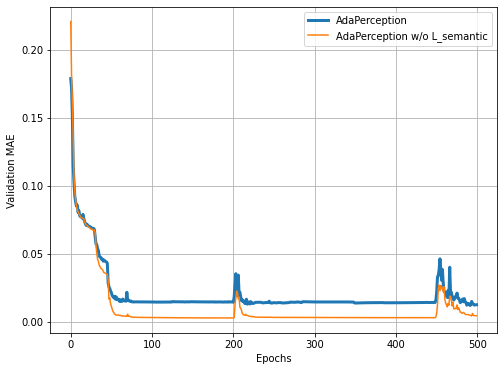

In [19]:
# evaluation: plot the learning curves
hist1 = hist_NL.history

import matplotlib.pyplot as plt
# loss figure
fig = plt.figure(figsize=(8,6))
plt.plot(hist1['val_loss'], 'b-')
plt.plot(hist1['loss'], 'b--')
plt.legend(['val_loss: NL', 'Loss:NL', 'val_loss', 'Loss'])
plt.grid()
plt.show()

# MAE figure
fig = plt.figure(figsize=(8, 6))
plt.plot(hist1['val_MAE'], '-', linewidth=3)

plt.plot(hist1['MAE'], '-')

plt.legend(['AdaPerception', 'AdaPerception w/o L_semantic', 'Training from scratch', 'C3D model'])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.savefig('filename.png', dpi=600)
plt.show()
